In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc, roc_curve,
                             average_precision_score)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna, missingno as msno, scipy.stats as stats, tqdm, warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv('/kaggle/input/testandtraindataseta/train_c.csv')
test_df = pd.read_csv('/kaggle/input/testandtraindataseta/test_c.csv')

RANDOM_STATE = 763

# **EDA**

In [ ]:
print( f"Размеры наборов данных: {test_df.shape}" )
print( "С признаками:", train_df.columns.tolist() )

Размеры наборов данных: (5000, 35)
С признаками: ['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'MaritalStatus', 'NumberOfDependents', 'HomeOwnershipStatus', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'EmploymentStatus', 'EducationLevel', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']


In [ ]:
print( "N/A в тренирочных данных:", train_df.shape[0] - train_df.dropna().shape[0] )
print( "N/A в тестовых данных:", test_df.shape[0] - test_df.dropna().shape[0] )

N/A в тренирочных данных: 1031
N/A в тестовых данных: 0


N/A не встречается в тестовой выборке. Следовательно, такие записи можно отбросить - влияние N/A будет только шумом.

In [102]:
train_df = train_df.dropna()

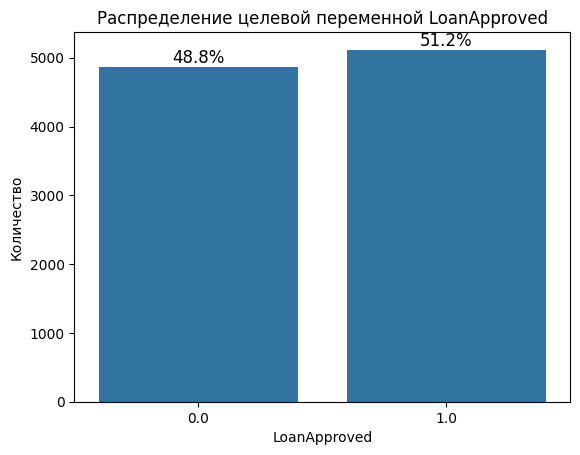

In [103]:
ax = sns.countplot(x='LoanApproved', data=train_df)
ax.set(title='Распределение целевой переменной LoanApproved', xlabel='LoanApproved', ylabel='Количество')
total = len(train_df)
for p in ax.patches:
    ax.annotate(f'{100 * p.get_height() / total:.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12)
plt.show()

Баланс классов нарушен слабо.

Признаков: 23


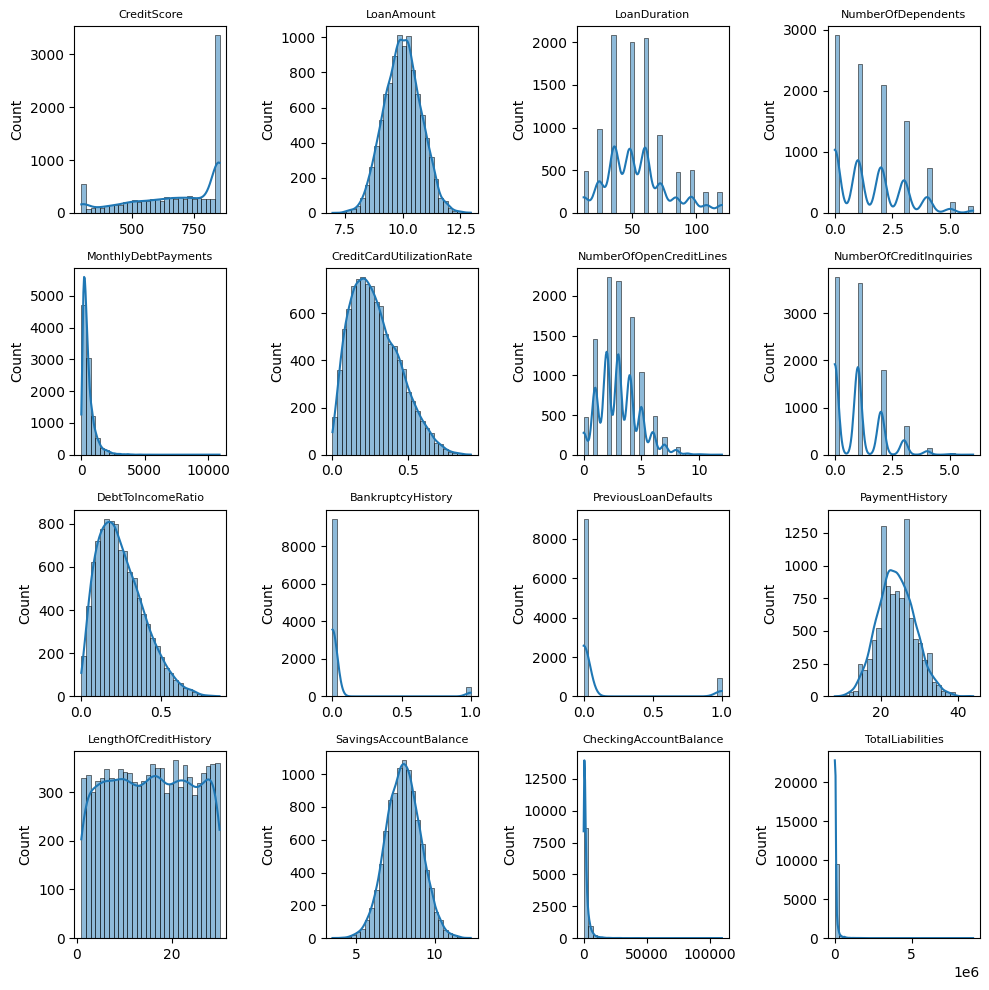

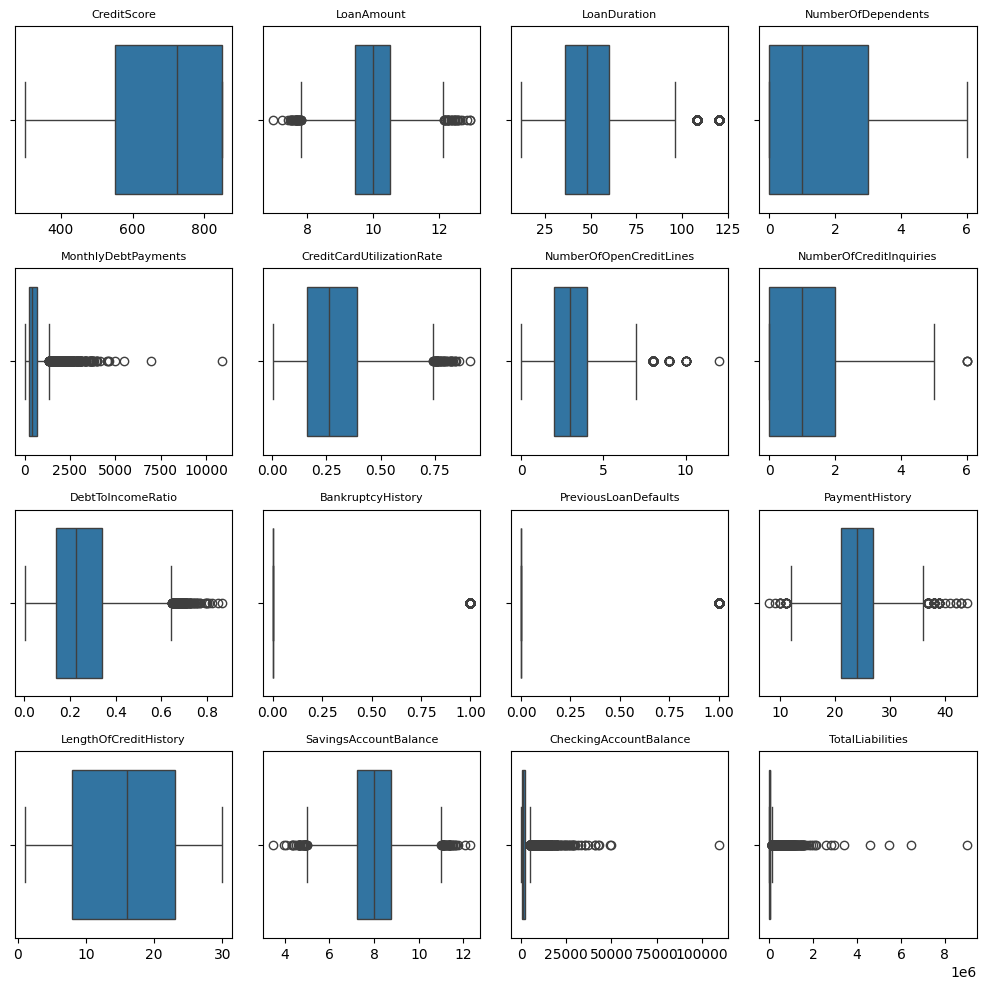

In [114]:
numeric_cols = train_df.copy().select_dtypes(np.number).columns.drop('LoanApproved').tolist()
print(f"Признаков: {len(numeric_cols)}")

for plot_type in ['hist', 'box']:
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols[:16]):
        if plot_type == 'hist':
            sns.histplot(train_df[col], ax=axes[i], kde=True, bins=30)
        else:
            sns.boxplot(data=train_df, x=col, ax=axes[i])
        axes[i].set_title(col, fontsize=8)
        axes[i].set_xlabel('')
    
    for ax in axes[i+1:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

БОльшая часть признаков скошена. Имеются признаки с выбросами.

Топ-12 признаков по корреляции с целевой переменной:
LoanApproved                  1.000000
MonthlyIncome                 0.754939
AnnualIncome                  0.742706
BaseInterestRate              0.605164
InterestRate                  0.600964
CreditScore                   0.581812
TotalDebtToIncomeRatio        0.477925
MonthlyLoanPayment            0.217305
LoanAmount                    0.195607
NetWorth                      0.129624
TotalAssets                   0.129204
MonthlyDebtPayments           0.044257
BankruptcyHistory             0.042160
LoanDuration                  0.036126
LengthOfCreditHistory         0.035093
Age                           0.034664
Experience                    0.034566
PreviousLoanDefaults          0.029472
UtilityBillsPaymentHistory    0.016759
DebtToIncomeRatio             0.014539
TotalLiabilities              0.012485
NumberOfCreditInquiries       0.012394
SavingsAccountBalance         0.009658
CheckingAccountBalance        0.009503
NumberOfDep

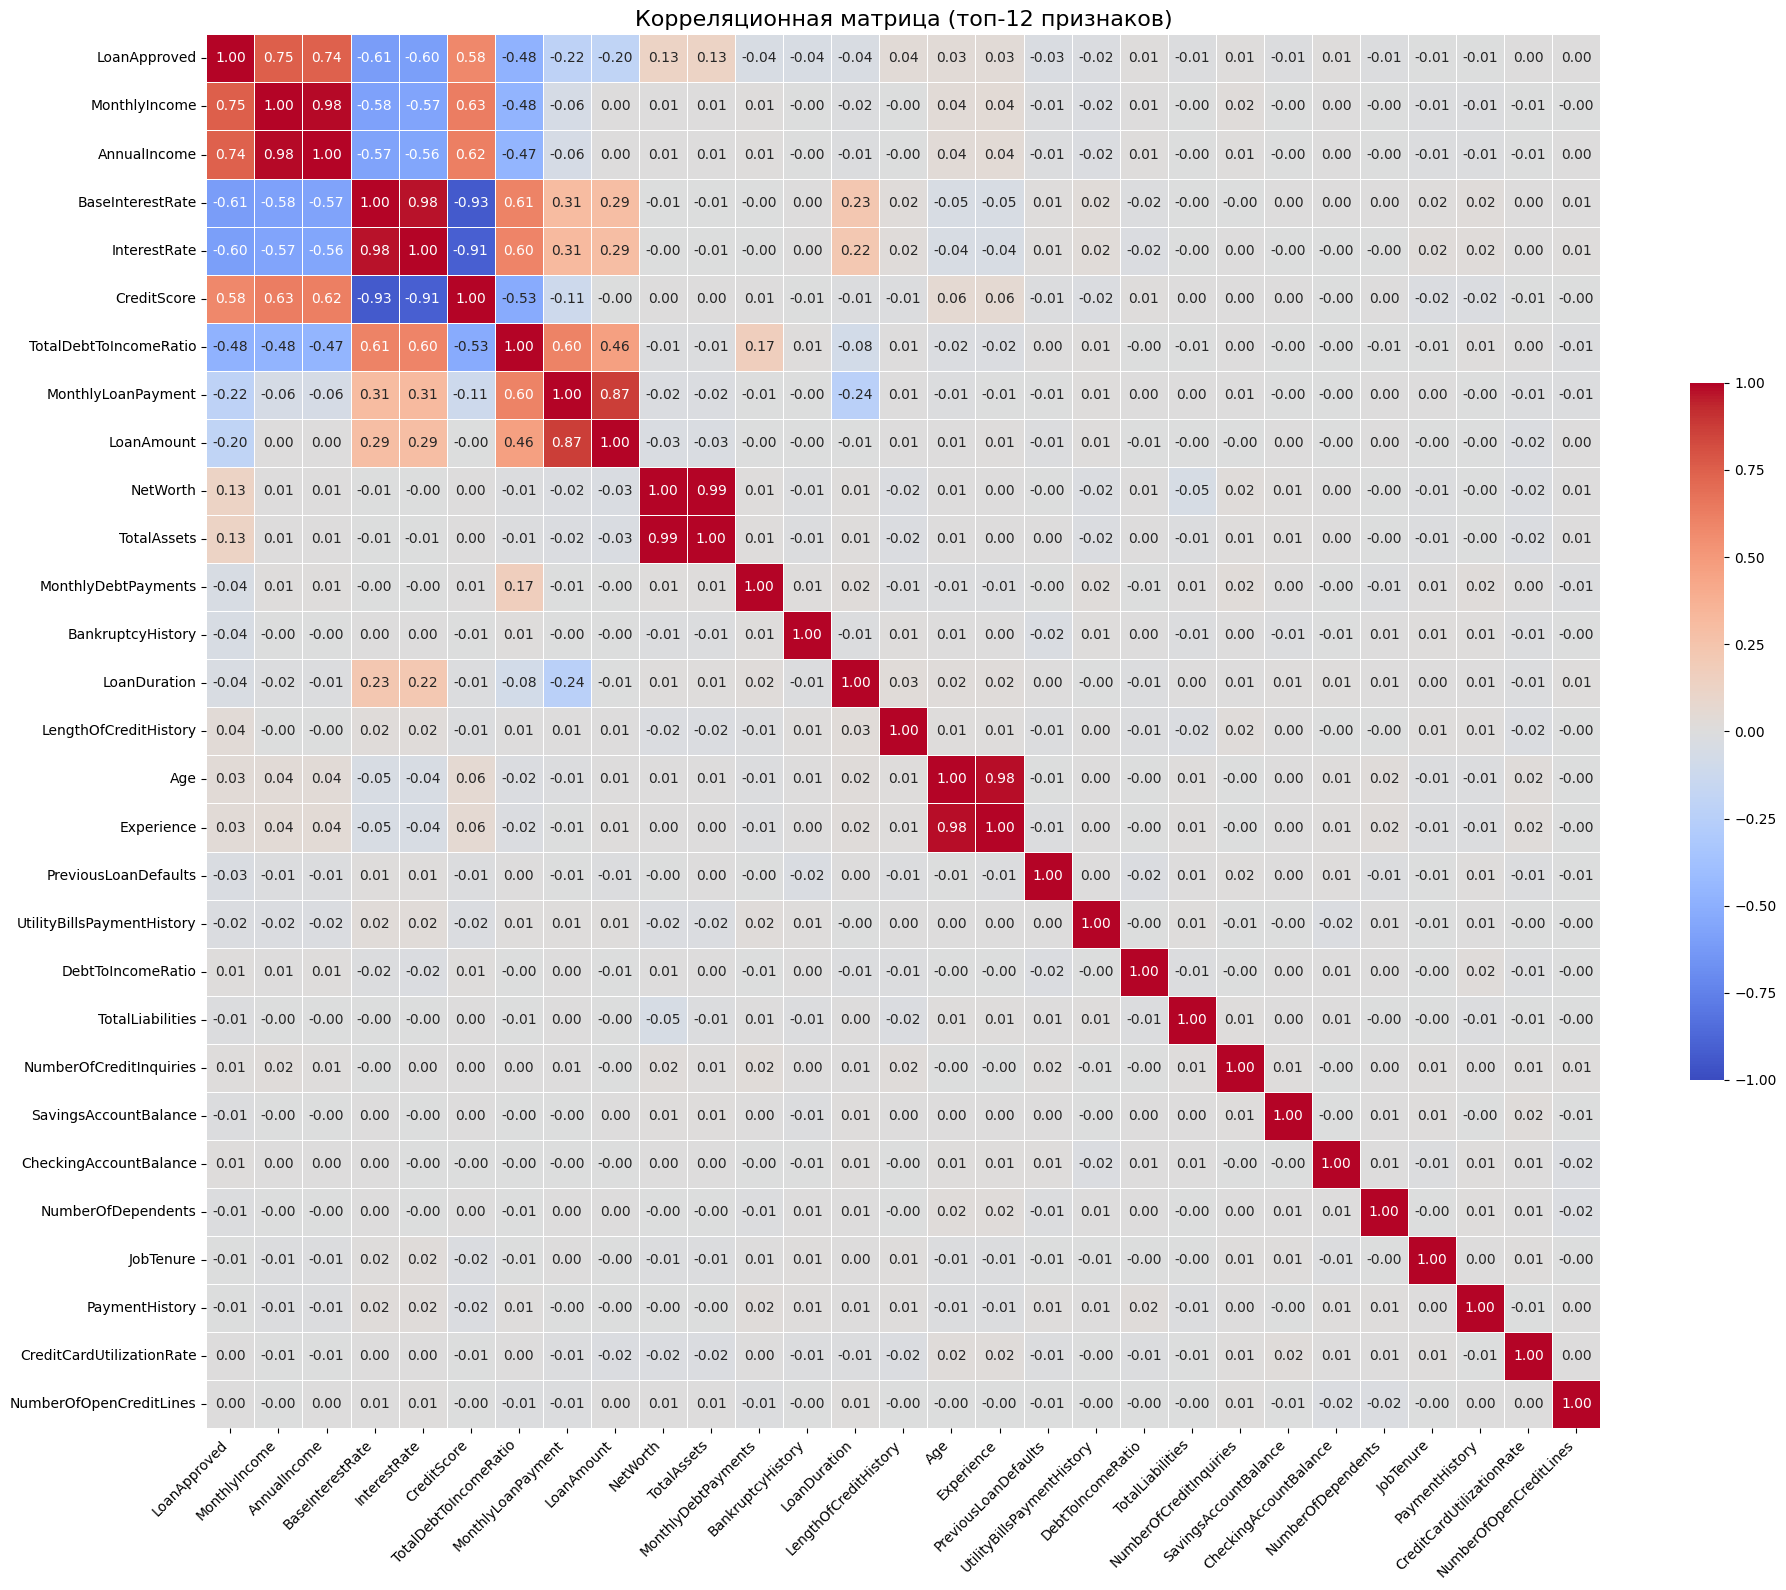

In [105]:
plt.figure(figsize=(20, 16))
corr_matrix = train_df[numeric_cols + ['LoanApproved']].corr()

target_corr = corr_matrix['LoanApproved'].sort_values(ascending=False)
print("Топ-12 признаков по корреляции с целевой переменной:")
print(target_corr.abs().sort_values(ascending=False))

top_corr_features = target_corr.abs().sort_values(ascending=False).index.tolist()
sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features], 
            annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Корреляционная матрица (топ-12 признаков)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Мультиколлинеарность присутствует у 5 признаков, из которых должны быть удалены AnnualIncome', 'TotalAssets', 'BaseInterestRate', 'MonthlyLoanPayment', 'Age', как наименее коррелирующие с целевой переменной.

In [106]:
collinear_features = ['AnnualIncome', 'TotalAssets', 'BaseInterestRate', 'MonthlyLoanPayment', 'Age']
train_df = train_df.drop(columns=collinear_features, errors='ignore')
test_df = test_df.drop(columns=collinear_features, errors='ignore')
target_corr = target_corr.drop(collinear_features, errors='ignore')

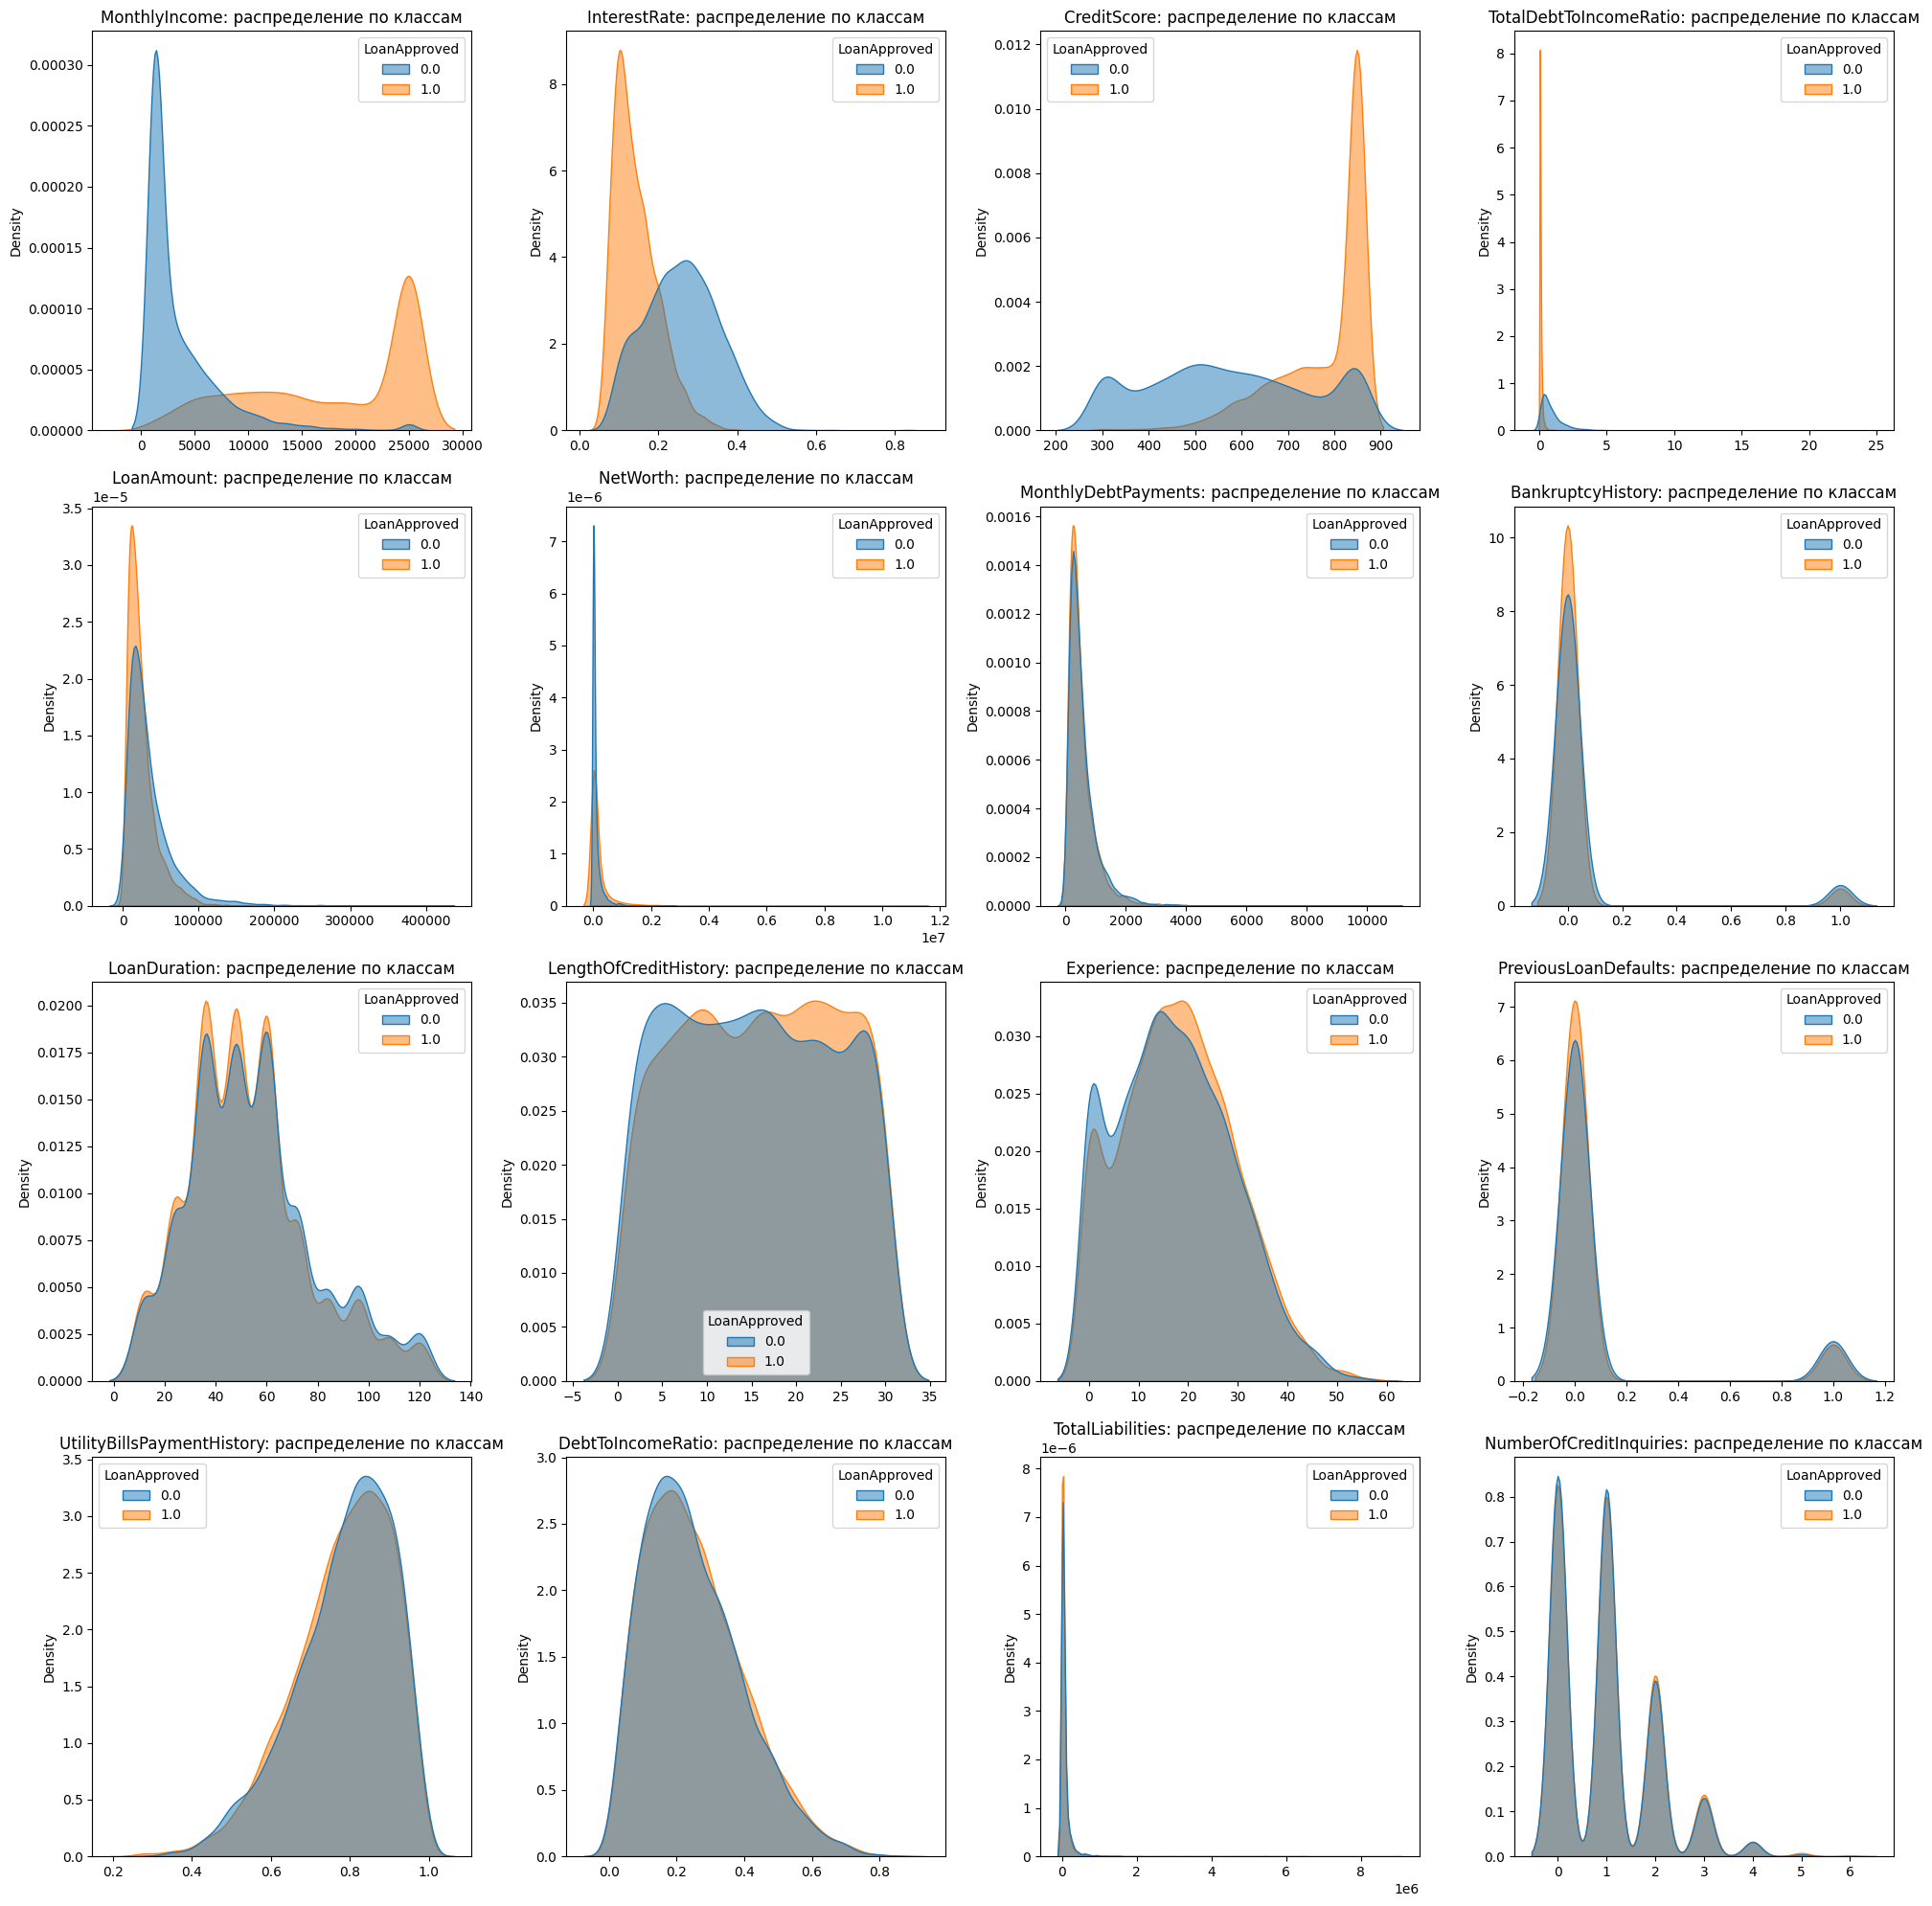

In [107]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
axes = axes.flatten()

top_features = target_corr.abs().sort_values(ascending=False).head(17).index.tolist()
top_features = [col for col in top_features if col != 'LoanApproved']

for i, col in enumerate(top_features[:16]):
    sns.kdeplot(data=train_df, x=col, hue='LoanApproved', fill=True, 
                common_norm=False, alpha=0.5, ax=axes[i])
    axes[i].set_title(f'{col}: распределение по классам', fontsize=12)
    axes[i].set_xlabel('')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Разделение по классам показывает картину, где у разных метрик либо существует серьезное разделение по LoanApprove, либо категории почти полностью совпадает.

# **Metrics**

In [110]:
def tp_fp_fn(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp, fp, fn

def manual_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def manual_precision(y_true, y_pred):
    tp, fp, _ = tp_fp_fn(y_true, y_pred)
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def manual_recall(y_true, y_pred):
    tp, _, fn = tp_fp_fn(y_true, y_pred)
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def manual_f1(y_true, y_pred):
    p, r = manual_precision(y_true, y_pred), manual_recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

def manual_auc_roc(y_true, y_score):
    idx = np.argsort(y_score)[::-1]
    y_true, y_score = y_true[idx], y_score[idx]
    
    thresholds = np.unique(y_score)[::-1]
    tpr_vals, fpr_vals = [0.0], [0.0]
    
    for th in thresholds:
        y_pred = (y_score >= th).astype(int)
        tp, fp, fn = tp_fp_fn(y_true, y_pred)
        tn = len(y_true) - tp - fp - fn
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        tpr_vals.append(tpr)
        fpr_vals.append(fpr)
    
    tpr_vals.append(1.0); fpr_vals.append(1.0)
    return np.trapz(tpr_vals, fpr_vals)

def manual_auc_pr(y_true, y_pred_score):
    y_true, y_score = np.asarray(y_true), np.asarray(y_pred_score)
    idx = np.argsort(y_score)[::-1]
    y_true, y_score = y_true[idx], y_score[idx]
    
    total_pos = y_true.sum()
    if total_pos == 0:
        return 0.0
    
    precisions, recalls = [1.0], [0.0]
    
    for th in np.unique(y_score)[::-1]:
        mask = y_score >= th
        tp = y_true[mask].sum()
        fp = mask.sum() - tp
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / total_pos
        precisions.append(prec)
        recalls.append(rec)
    
    return np.trapz(precisions, recalls)

y_true = np.array([1, 0, 1, 1, 0, 0, 1])
y_pred = np.array([1, 0, 0, 1, 0, 1, 1])
y_score = np.array([0.9, 0.2, 0.4, 0.8, 0.3, 0.7, 0.95])

metrics = {
    "Accuracy": (manual_accuracy, accuracy_score, y_pred, None),
    "Precision": (manual_precision, precision_score, y_pred, None),
    "Recall": (manual_recall, recall_score, y_pred, None),
    "F1-score": (manual_f1, f1_score, y_pred, None),
    "AUC-ROC": (manual_auc_roc, roc_auc_score, y_score, "score"),
    "AUC-PR": (manual_auc_pr, average_precision_score, y_score, "score"),
}

print(f"{'Метрика':<10} | {'Ручная':>8} | {'sklearn':>8} | {'Δ abs':>8} | {'Δ %':>8}")
print("-" * 52)

for name, (manual_fn, sklearn_fn, y, mode) in metrics.items():
    y_input = y_score if mode == "score" else y_pred
    m_val = manual_fn(y_true, y_input)
    s_val = sklearn_fn(y_true, y_input)
    diff_abs = abs(m_val - s_val)
    diff_pct = diff_abs / s_val * 100 if s_val != 0 else 0.0
    print(f"{name:<10} | {m_val:8.4f} | {s_val:8.4f} | {diff_abs:8.4f} | {diff_pct:7.2f}%")

Метрика    |   Ручная |  sklearn |    Δ abs |      Δ %
----------------------------------------------------
Accuracy   |   0.7143 |   0.7143 |   0.0000 |    0.00%
Precision  |   0.7500 |   0.7500 |   0.0000 |    0.00%
Recall     |   0.7500 |   0.7500 |   0.0000 |    0.00%
F1-score   |   0.7500 |   0.7500 |   0.0000 |    0.00%
AUC-ROC    |   0.9167 |   0.9167 |   0.0000 |    0.00%
AUC-PR     |   0.9437 |   0.9500 |   0.0062 |    0.66%


# **Boosting**

In [ ]:
class MyGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def fit(self, X, y):
        X, y = np.asarray(X), np.asarray(y)
        self.n_features_in_ = X.shape[1]

        p = np.clip(y.mean(), 1e-10, 1 - 1e-10)
        self.init_ = np.log(p / (1 - p))
        raw_preds = np.full(len(y), self.init_)

        self.estimators_ = []
        for i in range(self.n_estimators):
            residuals = y - self._sigmoid(raw_preds)
            
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state + i
            ).fit(X, residuals)
            
            self.estimators_.append(tree)
            raw_preds += self.learning_rate * tree.predict(X)

        return self

    def predict_proba(self, X):
        raw_preds = np.full(len(X), self.init_)
        for tree in self.estimators_:
            raw_preds += self.learning_rate * tree.predict(X)
        proba_pos = self._sigmoid(raw_preds)
        return np.column_stack([1 - proba_pos, proba_pos])

    def predict(self, X):
        if hasattr(self, 'n_features_in_') and X.shape[1] != self.n_features_in_:
            raise ValueError(f"Expected {self.n_features_in_} features, got {X.shape[1]}")
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

# **Bagging**

In [ ]:
class MyBaggingClassifier:    
    def __init__(self, base_estimator=None, n_estimators=10, 
                 max_samples=1.0, random_state=RANDOM_STATE):
        self.base_estimator = base_estimator or DecisionTreeClassifier(max_depth=3)
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.random_state = random_state
        self.estimators_ = []
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        n_subsamples = int(self.max_samples * n_samples)
        rng = np.random.RandomState(self.random_state)
        self.estimators_ = []
        for i in range(self.n_estimators):
            indices = resample(
                np.arange(n_samples),
                n_samples=n_subsamples,
                random_state=rng)
            X_sub = X[indices]
            y_sub = y[indices]
            estimator = self.base_estimator.clone() if hasattr(self.base_estimator, 'clone') else self.base_estimator
            estimator.fit(X_sub, y_sub)
            self.estimators_.append(estimator)
        return self
    
    def predict(self, X):
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        predictions = predictions.astype(int)
        return np.apply_along_axis(
            lambda x: np.bincount(x, minlength=2).argmax(),
            axis=0,
            arr=predictions
        )
    
    def predict_proba(self, X):
        probas = np.array([estimator.predict_proba(X) for estimator in self.estimators_])
        return np.mean(probas, axis=0)

In [123]:
def cap_outliers_iqr(series, multiplier=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - multiplier * iqr, q3 + multiplier * iqr
    return series.clip(lower=lower, upper=upper)

moderate_outlier_features = ['LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments']
skewed_features = ['SavingsAccountBalance', 'LoanAmount']

for col in moderate_outlier_features:
    if col in train_df.columns:
        train_df[col] = cap_outliers_iqr(train_df[col])
        test_df[col] = cap_outliers_iqr(test_df[col])

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
for col in skewed_features:
    if col in train_df.columns and col in test_df.columns:
        for df in (train_df, test_df):
            df[col] = np.where(df[col] <= 0, 1e-5, df[col])
        train_df[col] = log_transformer.fit_transform(train_df[[col]].values).flatten()
        test_df[col] = log_transformer.transform(test_df[[col]].values).flatten()

In [124]:

y = train_df['LoanApproved']
X = train_df.drop(columns=['LoanApproved'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}")
print(f"Train class distribution: {np.bincount(y_train) / len(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val) / len(y_val)}")

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"Размер обработанных данных:")
print(f"Train: {X_train_processed.shape}, Validation: {X_val_processed.shape}")

Train size: 7988, Validation size: 1998
Train class distribution: [0.4877316 0.5122684]
Validation class distribution: [0.48748749 0.51251251]
Размер обработанных данных:
Train: (7988, 7737), Validation: (1998, 7737)


In [ ]:
manual_bagging = MyBaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=50,
    random_state=RANDOM_STATE
)

manual_bagging.fit(X_train_processed, y_train.values)
y_pred_manual_bagging = manual_bagging.predict(X_val_processed)
y_proba_manual_bagging = manual_bagging.predict_proba(X_val_processed)[:, 1]

sklearn_bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

sklearn_bagging.fit(X_train_processed, y_train)
y_pred_sklearn_bagging = sklearn_bagging.predict(X_val_processed)
y_proba_sklearn_bagging = sklearn_bagging.predict_proba(X_val_processed)[:, 1]

print("Сравнение Bagging:")
print(f"Manual Bagging - Accuracy: {accuracy_score(y_val, y_pred_manual_bagging):.4f}, "
      f"AUC-ROC: {roc_auc_score(y_val, y_proba_manual_bagging):.4f}")
print(f"Sklearn Bagging - Accuracy: {accuracy_score(y_val, y_pred_sklearn_bagging):.4f}, "
      f"AUC-ROC: {roc_auc_score(y_val, y_proba_sklearn_bagging):.4f}")

Сравнение Bagging:
Manual Bagging - Accuracy: 0.8954, AUC-ROC: 0.9581
Sklearn Bagging - Accuracy: 0.9084, AUC-ROC: 0.9723


In [ ]:
models = {
    'Manual GB': MyGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE),
    'Sklearn GB': GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
}

results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_val_processed)
    y_proba = model.predict_proba(X_val_processed)[:, 1]
    results[name] = {
        'acc': accuracy_score(y_val, y_pred),
        'auc': roc_auc_score(y_val, y_proba)
    }

print("Сравнение Gradient Boosting:")
for name, metrics in results.items():
    print(f"{name:>11} - Accuracy: {metrics['acc']:.4f}, AUC-ROC: {metrics['auc']:.4f}")

KeyboardInterrupt: 

In [ ]:
models = {
    'Manual GB': MyGBClassifier(random_state=RANDOM_STATE),
    'Sklearn GB': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
}

results = []
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_val_processed)
    y_proba = model.predict_proba(X_val_processed)[:, 1]
    results.append({
        'model': name,
        'accuracy': accuracy_score(y_val, y_pred),
        'auc_roc': roc_auc_score(y_val, y_proba)
    })

print("Результаты моделей:")
for r in results:
    print(f"{r['model']:<12} | Accuracy: {r['accuracy']:.4f} | AUC-ROC: {r['auc_roc']:.4f}")

best = max(results, key=lambda x: x['auc_roc'])
print(f"\nЛучшая модель: {best['model']} (AUC-ROC: {best['auc_roc']:.4f})")


Обучение Manual GB...
Manual GB - Accuracy: 0.9149, AUC-ROC: 0.9760

Обучение Sklearn GB...
Sklearn GB - Accuracy: 0.9269, AUC-ROC: 0.9841

Обучение LightGBM...
[LightGBM] [Info] Number of positive: 4092, number of negative: 3896
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3586
[LightGBM] [Info] Number of data points in the train set: 7988, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512268 -> initscore=0.049083
[LightGBM] [Info] Start training from score 0.049083
LightGBM - Accuracy: 0.9389, AUC-ROC: 0.9862

Обучение XGBoost...
XGBoost - Accuracy: 0.9394, AUC-ROC: 0.9859

Обучение CatBoost...
CatBoost - Accuracy: 0.9309, AUC-ROC: 0.9845

Лучшая модель: LightGBM с AUC-ROC: 0.9862


# **Подбор гиперпараметров с Optuna**

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    model = LGBMClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )
    model.fit(X_train_processed, y_train)
    return roc_auc_score(y_val, model.predict_proba(X_val_processed)[:, 1])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
final_model = LGBMClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
final_model.fit(X_train_processed, y_train)

y_pred = final_model.predict(X_val_processed)
y_proba = final_model.predict_proba(X_val_processed)[:, 1]
acc = accuracy_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

print(f"Лучшие параметры: {best_params}")
print(f"Лучшее AUC-ROC (валидация): {study.best_value:.4f}")
print(f"Финальная модель — Accuracy: {acc:.4f}, AUC-ROC: {auc:.4f}")


Лучшие параметры: {'n_estimators': 215, 'learning_rate': 0.07473722971750064, 'max_depth': 5, 'subsample': 0.8728624626611683, 'colsample_bytree': 0.7820137114989285, 'reg_alpha': 0.000682290495964265, 'reg_lambda': 5.149372355681229e-06}
Лучшее значение AUC-ROC: 0.9872

Финальная модель - Accuracy: 0.9409, AUC-ROC: 0.9872


# Graphs

In [ ]:
def plot_curve(x, y, xlabel, ylabel, title, auc_val, color, linestyle='-', legend_pos='lower right'):
    plt.figure(figsize=(10, 8))
    plt.plot(x, y, color=color, lw=2, label=f'{title} (AUC = {auc_val:.4f})')
    if title == 'ROC Curve': plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc=legend_pos)
    plt.show()

fpr, tpr, _ = roc_curve(y_val, y_proba_final)
plot_curve(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC Curve',
           auc(fpr, tpr), 'darkorange', legend_pos='lower right')

precision, recall, _ = precision_recall_curve(y_val, y_proba_final)
plot_curve(recall, precision, 'Recall', 'Precision', 'Precision-Recall Curve',
           auc(recall, precision), 'blue', legend_pos='lower left')

# Submission 

In [ ]:
test_df = pd.read_csv(test_path)
X_test = test_df.drop(columns=['ID'])
X_test_processed = preprocessor.transform(X_test)

test_pred = final_model.predict(X_test_processed)

submission = pd.DataFrame({
    'ID': test_df['ID'],
    'LoanApproved': test_pred
})

submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

print("Распределение предсказаний:\n", submission['LoanApproved'].value_counts(normalize=True))
print(f"ROC-AUC на валидации: {roc_auc:.4f}")